# Movie Recommendation with Content-Based and Collaborative Filtering
“*What movie should I watch this evening?*” 

Have you ever had to answer this question at least once when you came home from work? As for me — yes, and more than once. From Netflix to Hulu, the need to build robust movie recommendation systems is extremely important given the huge demand for personalized content of modern consumers.

An example of recommendation system is such as this:
* User A watches **Game of Thrones** and **Breaking Bad**.
* User B does search on **Game of Thrones**, then the system suggests **Breaking Bad** from data collected about user A.

Recommendation systems are used not only for movies, but on multiple other products and services like Amazon (Books, Items), Pandora/Spotify (Music), Google (News, Search), YouTube (Videos) etc.

![netflix](images/netflix.png)

Two most ubiquitous types of personalized recommendation systems are **Content-Based** and **Collaborative Filtering**. Collaborative filtering produces recommendations based on the knowledge of users’ attitude to items, that is it uses the “wisdom of the crowd” to recommend items. In contrast, content-based recommendation systems focus on the attributes of the items and give you recommendations based on the similarity between them.

In this notebook, I will attempt at implementing these two systems to recommend movies and evaluate them to see which one performs better.

After reading this post you will know:

* About the MovieLens dataset problem for recommender system.
* How to load and process the data.
* How to do exploratory data analysis.
* The 2 different types of recommendation engines.
* How to develop a content-based recommendation model based on movie genres.
* How to develop a collaborative filtering model based on user ratings.
* Alternative approach to improve existing models.

Let’s get started.

## The MovieLens Dataset
One of the most common datasets that is available on the internet for building a Recommender System is the [MovieLens DataSet](https://grouplens.org/datasets/movielens/). This version of the dataset that I'm working with ([1M](https://grouplens.org/datasets/movielens/1m/)) contains 1,000,209 anonymous ratings of approximately 3,900 movies made by 6,040 MovieLens users who joined MovieLens in 2000.

The data was collected by GroupLens researchers over various periods of time, depending on the size of the set. This 1M version was released on February 2003. Users were selected at random for inclusion. All users selected had rated at least 20 movies. Each user is represented by an id, and no other information is provided.

The original data are contained in three files, [movies.dat](https://github.com/khanhnamle1994/movielens/blob/master/dat/movies.dat), [ratings.dat](https://github.com/khanhnamle1994/movielens/blob/master/dat/ratings.dat) and [users.dat](https://github.com/khanhnamle1994/movielens/blob/master/dat/users.dat). To make it easier to work with the data, I converted them into csv files. The process can be viewed in my [Data Processing Notebook](https://github.com/khanhnamle1994/movielens/blob/master/Data_Processing.ipynb).

![movielens](images/movielens.jpg)

## Data Preparation
Let's load this data into Python. I will load the dataset with Pandas onto Dataframes **ratings**, **users**, and **movies**. Before that, I'll also pass in column names for each CSV and read them using pandas (the column names are available in the [Readme](https://github.com/khanhnamle1994/movielens/blob/master/README.md) file).

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Reading ratings file
# Ignore the timestamp column
ratings = pd.read_csv('ratings.csv', sep='\t', encoding='latin-1', usecols=['user_id', 'movie_id', 'rating'])

# Reading users file
users = pd.read_csv('users.csv', sep='\t', encoding='latin-1', usecols=['user_id', 'gender', 'zipcode', 'age_desc', 'occ_desc'])

# Reading movies file
movies = pd.read_csv('movies.csv', sep='\t', encoding='latin-1', usecols=['movie_id', 'title', 'genres'])

Now lets take a peak into the content of each file to understand them better.

### Ratings Dataset

In [20]:
# Check the top 5 rows
print(ratings.head())

   user_id  movie_id  rating
0        1      1193       5
1        1       661       3
2        1       914       3
3        1      3408       4
4        1      2355       5


In [21]:
# Check the file info
print(ratings.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 3 columns):
user_id     1000209 non-null int64
movie_id    1000209 non-null int64
rating      1000209 non-null int64
dtypes: int64(3)
memory usage: 22.9 MB
None


This confirms that there are 1M ratings for different user and movie combinations.

### Users Dataset

In [22]:
# Check the top 5 rows
print(users.head())

   user_id gender zipcode  age_desc              occ_desc
0        1      F   48067  Under 18          K-12 student
1        2      M   70072       56+         self-employed
2        3      M   55117     25-34             scientist
3        4      M   02460     45-49  executive/managerial
4        5      M   55455     25-34                writer


In [23]:
# Check the file info
print(users.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
user_id     6040 non-null int64
gender      6040 non-null object
zipcode     6040 non-null object
age_desc    6040 non-null object
occ_desc    6040 non-null object
dtypes: int64(1), object(4)
memory usage: 236.0+ KB
None


This confirms that there are 6040 users and we have 5 features for each (unique user ID, gender, age, occupation and the zip code they are living in).

### Movies Dataset

In [24]:
# Check the top 5 rows
print(movies.head())

   movie_id                               title                        genres
0         1                    Toy Story (1995)   Animation|Children's|Comedy
1         2                      Jumanji (1995)  Adventure|Children's|Fantasy
2         3             Grumpier Old Men (1995)                Comedy|Romance
3         4            Waiting to Exhale (1995)                  Comedy|Drama
4         5  Father of the Bride Part II (1995)                        Comedy


In [25]:
# Check the file info
print(movies.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
movie_id    3883 non-null int64
title       3883 non-null object
genres      3883 non-null object
dtypes: int64(1), object(2)
memory usage: 91.1+ KB
None


This dataset contains attributes of the 3883 movies. There are 3 columns including the movie ID, their titles, and their genres. Genres are pipe-separated and are selected from 18 genres (Action, Adventure, Animation, Children's, Comedy, Crime, Documentary, Drama, Fantasy, Film-Noir, Horror, Musical, Mystery, Romance, Sci-Fi, Thriller, War, Western).

## Data Exploration
### Titles
Are there certain words that feature more often in Movie Titles? I'll attempt to figure this out using a word-cloud visualization.

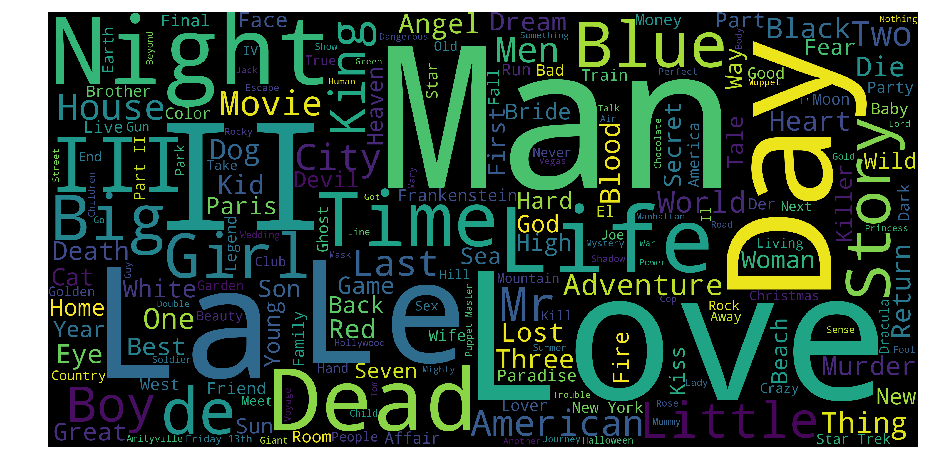

In [26]:
# Import new libraries
%matplotlib inline
import wordcloud
from wordcloud import WordCloud, STOPWORDS

# Create a wordcloud of the movie titles
movies['title'] = movies['title'].fillna("").astype('str')
title_corpus = ' '.join(movies['title'])
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', height=2000, width=4000).generate(title_corpus)

# Plot the wordcloud
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

Beautiful, isn't it? I can recognize that there are a lot of movie franchises in this dataset, as evidenced by words like *II* and *III*... In addition to that, *Day*, *Love*, *Life*, *Time*, *Night*, *Man*, *Dead*, *American* are among the most commonly occuring words.

### Ratings
Next I want to examine the **rating** further. Let's take a look at its summary statistics and distribution.

In [27]:
# Get summary statistics of rating
ratings['rating'].describe()

count    1.000209e+06
mean     3.581564e+00
std      1.117102e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

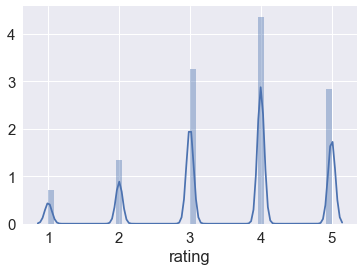

In [28]:
# Import seaborn library
import seaborn as sns
sns.set_style('whitegrid')
sns.set(font_scale=1.5)
%matplotlib inline

# Display distribution of rating
sns.distplot(ratings['rating'].fillna(ratings['rating'].median()))

It appears that users are quite generous in their ratings. The mean rating is 3.58 on a scale of 5. Half the movies have a rating of 4 and 5. I personally think that a 5-level rating skill wasn’t a good indicator as people could have different rating styles (i.e. person A could always use 4 for an average movie, whereas person B only gives 4 out for their favorites). Each user rated at least 20 movies, so I doubt the distribution could be caused just by chance variance in the quality of movies.

Let's also take a look at a subset of 20 movies with the highest rating.

In [31]:
# Join all 3 files into one dataframe
dataset = pd.merge(pd.merge(movies )
# Display 20 movies with highest ratingsratings),users
dataset[['title','genres','rating']].sort_values('rating', ascending=False).head(20)

SyntaxError: invalid syntax (<ipython-input-31-b1f6e4e06f44>, line 4)

### Genres
The genres variable will surely be important while building the recommendation engines since it describes the content of the film (i.e. Animation, Horror, Sci-Fi). A basic assumption is that films in the same genre should have similar contents. I'll attempt to see exactly which genres are the most popular.

In [32]:
# Make a census of the genre keywords
genre_labels = set()
for s in movies['genres'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))

# Function that counts the number of times each of the genre keywords appear
def count_word(dataset, ref_col, census):
    keyword_count = dict()
    for s in census: 
        keyword_count[s] = 0
    for census_keywords in dataset[ref_col].str.split('|'):        
        if type(census_keywords) == float and pd.isnull(census_keywords): 
            continue        
        for s in [s for s in census_keywords if s in census]: 
            if pd.notnull(s): 
                keyword_count[s] += 1
    #______________________________________________________________________
    # convert the dictionary in a list to sort the keywords by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

# Calling this function gives access to a list of genre keywords which are sorted by decreasing frequency
keyword_occurences, dum = count_word(movies, 'genres', genre_labels)
keyword_occurences[:5]

[['Drama', 1603],
 ['Comedy', 1200],
 ['Action', 503],
 ['Thriller', 492],
 ['Romance', 471]]

The top 5 genres are, in that respect order: Drama, Comedy, Action, Thriller, and Romance. I'll show this on a wordcloud too in order to make it more visually appealing.

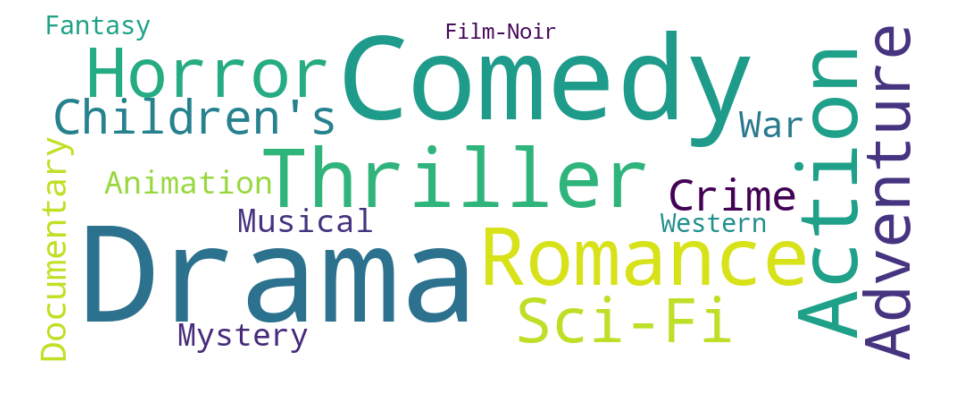

In [33]:
# Define the dictionary used to produce the genre wordcloud
genres = dict()
trunc_occurences = keyword_occurences[0:18]
for s in trunc_occurences:
    genres[s[0]] = s[1]

# Create the wordcloud
genre_wordcloud = WordCloud(width=1000,height=400, background_color='white')
genre_wordcloud.generate_from_frequencies(genres)

# Plot the wordcloud
f, ax = plt.subplots(figsize=(16, 8))
plt.imshow(genre_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## Types of Recommendation Engines

### 1. Content-Based
The Content-Based Recommender relies on the similarity of the items being recommended. The basic idea is that if you like an item, then you will also like a “similar” item. It generally works well when it's easy to determine the context/properties of each item.

A content based recommender works with data that the user provides, either explicitly movie ratings for the MovieLens dataset. Based on that data, a user profile is generated, which is then used to make suggestions to the user. As the user provides more inputs or takes actions on the recommendations, the engine becomes more and more accurate.

### 2. Collaborative Filtering
The Collaborative Filtering Recommender is entirely based on the past behavior and not on the context. More specifically, it is based on the similarity in preferences, tastes and choices of two users. It analyses how similar the tastes of one user is to another and makes recommendations on the basis of that. 

For instance, if user A likes movies 1, 2, 3 and user B likes movies 2,3,4, then they have similar interests and A should like movie 4 and B should like movie 1. This makes it one of the most commonly used algorithm as it is not dependent on any additional information.

In general, collaborative filtering is the workhorse of recommender engines. The algorithm has a very interesting property of being able to do feature learning on its own, which means that it can start to learn for itself what features to use. It can be divided into **Memory-Based Collaborative Filtering** and **Model-Based Collaborative filtering**. In this post, I'll only focus on the Memory-Based Collaborative Filtering technique.

![rec-systems](images/rec-systems.png)

## Content-Based Recommendation Model
### Theory
The concepts of **Term Frequency (TF)** and **Inverse Document Frequency (IDF)** are used in information retrieval systems and also content based filtering mechanisms (such as a content based recommender). They are used to determine the relative importance of a document / article / news item / movie etc.

TF is simply the frequency of a word in a document. IDF is the inverse of the document frequency among the whole corpus of documents. TF-IDF is used mainly because of two reasons: Suppose we search for “**the results of latest European Socccer games**” on Google. It is certain that “**the**” will occur more frequently than “**soccer games**” but the relative importance of **soccer games** is higher than the search query point of view. In such cases, TF-IDF weighting negates the effect of high frequency words in determining the importance of an item (document).

Below is the equation to calculate the TF-IDF score:
![tfidf](images/tfidf.jpg)

After calculating TF-IDF scores, how do we determine which items are closer to each other, rather closer to the user profile? This is accomplished using the **Vector Space Model** which computes the proximity based on the angle between the vectors. In this model, each item is stored as a vector of its attributes (which are also vectors) in an **n-dimensional space** and the angles between the vectors are calculated to **determine the similarity between the vectors**. Next, the user profile vectors are also created based on his actions on previous attributes of items and the similarity between an item and a user is also determined in a similar way.

![vector-space](images/vector_space.png)

Sentence 2 is more likely to be using Term 2 than using Term 1. Vice-versa for Sentence 1. The method of calculating this relative measure is calculated by taking the cosine of the angle between the sentences and the terms. The ultimate reason behind using cosine is that the **value of cosine will increase with decreasing value of the angle** between which signifies more similarity. The vectors are length normalized after which they become vectors of length 1 and then the cosine calculation is simply the sum-product of vectors.

### Implementation
With all that theory in mind, I am going to build a Content-Based Recommendation Engine that computes similarity between movies based on movie genres. It will suggest movies that are most similar to a particular movie based on its genre. To do so, I will make use of the file **movies.csv**.

In [34]:
# Break up the big genre string into a string array
movies['genres'] = movies['genres'].str.split('|')
# Convert genres to string value
movies['genres'] = movies['genres'].fillna("").astype('str')

I do not have a quantitative metric to judge our machine's performance so this will have to be done qualitatively. In order to do so, I'll use **TfidfVectorizer** function from **scikit-learn**, which transforms text to feature vectors that can be used as input to estimator.

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(movies['genres'])
tfidf_matrix.shape

(3883, 127)

I will be using the **[Cosine Similarity](https://masongallo.github.io/machine/learning,/python/2016/07/29/cosine-similarity.html)** to calculate a numeric quantity that denotes the similarity between two movies. Since we have used the TF-IDF Vectorizer, calculating the Dot Product will directly give us the Cosine Similarity Score. Therefore, we will use sklearn's **linear_kernel** instead of cosine_similarities since it is much faster.

In [36]:
from sklearn.metrics.pairwise import linear_kernel
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim[:4, :4]

array([[ 1.        ,  0.14193614,  0.09010857,  0.1056164 ],
       [ 0.14193614,  1.        ,  0.        ,  0.        ],
       [ 0.09010857,  0.        ,  1.        ,  0.1719888 ],
       [ 0.1056164 ,  0.        ,  0.1719888 ,  1.        ]])

I now have a pairwise cosine similarity matrix for all the movies in the dataset. The next step is to write a function that returns the 20 most similar movies based on the cosine similarity score.

In [37]:
# Build a 1-dimensional array with movie titles
titles = movies['title']
indices = pd.Series(movies.index, index=movies['title'])

# Function that get movie recommendations based on the cosine similarity score of movie genres
def genre_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:21]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

Let's try and get the top recommendations for a few movies and see how good the recommendations are.

In [38]:
genre_recommendations('Now and Then (1995)').head(20)

25                                        Othello (1995)
26                                   Now and Then (1995)
29     Shanghai Triad (Yao a yao yao dao waipo qiao) ...
30                                Dangerous Minds (1995)
35                               Dead Man Walking (1995)
39                       Cry, the Beloved Country (1995)
42                                    Restoration (1995)
52                                       Lamerica (1994)
54                                        Georgia (1995)
56                          Home for the Holidays (1995)
61                             Mr. Holland's Opus (1995)
66                                       Two Bits (1995)
77                            Crossing Guard, The (1995)
79          White Balloon, The (Badkonake Sefid ) (1995)
81                       Antonia's Line (Antonia) (1995)
82       Once Upon a Time... When We Were Colored (1995)
89                    Journey of August King, The (1995)
92                             

In [39]:
genre_recommendations('Toy Story (1995)').head(20)

1050               Aladdin and the King of Thieves (1996)
2072                             American Tail, An (1986)
2073           American Tail: Fievel Goes West, An (1991)
2285                            Rugrats Movie, The (1998)
2286                                 Bug's Life, A (1998)
3045                                   Toy Story 2 (1999)
3542                                Saludos Amigos (1943)
3682                                   Chicken Run (2000)
3685       Adventures of Rocky and Bullwinkle, The (2000)
236                                 Goofy Movie, A (1995)
12                                           Balto (1995)
241                               Gumby: The Movie (1995)
310                             Swan Princess, The (1994)
592                                      Pinocchio (1940)
612                                Aristocats, The (1970)
700                               Oliver & Company (1988)
876     Land Before Time III: The Time of the Great Gi...
1010          

In [40]:
genre_recommendations('Saving Private Ryan (1998)').head(20)

461            Heaven & Earth (1993)
1204        Full Metal Jacket (1987)
1214     Boat, The (Das Boot) (1981)
1222                    Glory (1989)
1545                G.I. Jane (1997)
1959      Saving Private Ryan (1998)
2358       Thin Red Line, The (1998)
2993         Longest Day, The (1962)
3559            Flying Tigers (1942)
3574    Fighting Seabees, The (1944)
3585    Guns of Navarone, The (1961)
3684             Patriot, The (2000)
40                Richard III (1995)
153            Beyond Rangoon (1995)
332         Walking Dead, The (1995)
523          Schindler's List (1993)
641        Courage Under Fire (1996)
967          Nothing Personal (1995)
979           Michael Collins (1996)
1074                  Platoon (1986)
Name: title, dtype: object

As you can see, I have quite a decent list of recommendation for **Good Will Hunting** (Drama), **Toy Story** (Animation, Children's, Comedy), and **Saving Private Ryan** (Action, Thriller, War).

Overall, here are the pros of using content-based recommendation:
* No need for data on other users, thus no cold-start or sparsity problems.
* Can recommend to users with unique tastes.
* Can recommend new & unpopular items.
* Can provide explanations for recommended items by listing content-features that caused an item to be recommended (in this case, movie genres)

However, there are some cons of using this approach:
* Finding the appropriate features is hard.
* Does not recommend items outside a user's content profile.
* Unable to exploit quality judgments of other users.

## Collaborative Filtering Recommendation Model
The content based engine suffers from some severe limitations. It is only capable of suggesting movies which are close to a certain movie. That is, it is not capable of capturing tastes and providing recommendations across genres.

Also, the engine that we built is not really personal in that it doesn't capture the personal tastes and biases of a user. Anyone querying our engine for recommendations based on a movie will receive the same recommendations for that movie, regardless of who she/he is.

Therefore, in this section, I will use Memory-Based Collaborative Filtering to make recommendations to movie users. The technique is based on the idea that users similar to a me can be used to predict how much I will like a particular product or service those users have used/experienced but I have not.

### Theory
There are 2 main types of memory-based collaborative filtering algorithms:
1. **User-User Collaborative Filtering**: Here we find look alike users based on similarity and recommend movies which first user’s look-alike has chosen in past. This algorithm is very effective but takes a lot of time and resources. It requires to compute every user pair information which takes time. Therefore, for big base platforms, this algorithm is hard to implement without a very strong parallelizable system.
2. **Item-Item Collaborative Filtering**: It is quite similar to previous algorithm, but instead of finding user's look-alike, we try finding movie's look-alike. Once we have movie's look-alike matrix, we can easily recommend alike movies to user who have rated any movie from the dataset. This algorithm is far less resource consuming than user-user collaborative filtering. Hence, for a new user, the algorithm takes far lesser time than user-user collaborate as we don’t need all similarity scores between users. And with fixed number of movies, movie-movie look alike matrix is fixed over time.

![user_item_cf](images/user_item_cf.jpg)

In either scenario, we builds a similarity matrix. For user-user collaborative filtering, the **user-similarity matrix** will consist of some distance metrics that measure the similarity between any two pairs of users. Likewise, the **item-similarity matrix** will measure the similarity between any two pairs of items.

There are 3 distance similarity metrics that are usually used in collaborative filtering:
1. **Jaccard Similarity**:
    * Similarity is based on the number of users which have rated item A and B divided by the number of users who have rated either A or B
    * It is typically used where we don’t have a numeric rating but just a boolean value like a product being bought or an add being clicked

2. **Cosine Similarity**: (as in the Content-Based system)
    * Similarity is the cosine of the angle between the 2 vectors of the item vectors of A and B
    * Closer the vectors, smaller will be the angle and larger the cosine

3. **Pearson Similarity**:
    * Similarity is the pearson coefficient between the two vectors.

For the purpose of diversity, I will use **Pearson Similarity** in this implementation.

### Implementation
I will use the file **ratings.csv** first as it contains User ID, Movie IDs and Ratings. These three elements are all I need for determining the similarity of the users based on their ratings for a particular movie.

First I do some quick data processing:

In [41]:
# Fill NaN values in user_id and movie_id column with 0
ratings['user_id'] = ratings['user_id'].fillna(0)
ratings['movie_id'] = ratings['movie_id'].fillna(0)

# Replace NaN values in rating column with average of all values
ratings['rating'] = ratings['rating'].fillna(ratings['rating'].mean())

Due to the limited computing power in my laptop, I will build the recommender system using only a subset of the ratings. In particular, I will take a random sample of 20,000 ratings (2%) from the 1M ratings.

In [42]:
# Randomly sample 1% of the ratings dataset
small_data = ratings.sample(frac=0.02)
# Check the sample info
print(small_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20004 entries, 390248 to 237734
Data columns (total 3 columns):
user_id     20004 non-null int64
movie_id    20004 non-null int64
rating      20004 non-null int64
dtypes: int64(3)
memory usage: 625.1 KB
None


Now I use the **scikit-learn library** to split the dataset into testing and training.  **Cross_validation.train_test_split** shuffles and splits the data into two datasets according to the percentage of test examples, which in this case is 0.2.

In [44]:
from sklearn import cross_validation as cv
train_data, test_data = cv.train_test_split(small_data, test_size=0.2)

Now I need to create a user-item matrix. Since I have splitted the data into testing and training, I need to create two matrices. The training matrix contains 80% of the ratings and the testing matrix contains 20% of the ratings.

In [45]:
# Create two user-item matrices, one for training and another for testing
train_data_matrix = train_data.as_matrix(columns = ['user_id', 'movie_id', 'rating'])
test_data_matrix = test_data.as_matrix(columns = ['user_id', 'movie_id', 'rating'])

# Check their shape
print(train_data_matrix.shape)
print(test_data_matrix.shape)

(16003, 3)
(4001, 3)


Now I use the **pairwise_distances** function from sklearn to calculate the [Pearson Correlation Coefficient](https://stackoverflow.com/questions/1838806/euclidean-distance-vs-pearson-correlation-vs-cosine-similarity). This method provides a safe way to take a distance matrix as input, while preserving compatibility with many other algorithms that take a vector array.

In [46]:
from sklearn.metrics.pairwise import pairwise_distances

# User Similarity Matrix
user_correlation = 1 - pairwise_distances(train_data, metric='correlation')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation[:4, :4])

[[ 1.          0.98689298  0.80305584  0.93031562]
 [ 0.98689298  1.          0.88869481  0.85893566]
 [ 0.80305584  0.88869481  1.          0.52854177]
 [ 0.93031562  0.85893566  0.52854177  1.        ]]


In [47]:
# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(train_data_matrix.T, metric='correlation')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation[:4, :4])

[[ 1.         -0.00916243  0.00278597]
 [-0.00916243  1.         -0.05587646]
 [ 0.00278597 -0.05587646  1.        ]]


With the similarity matrix in hand, I can now predict the ratings that were not included with the data. Using these predictions, I can then compare them with the test data to attempt to validate the quality of our recommender model.

For the user-user CF case, I will look at the similarity between 2 users (A and B, for example) as weights that are multiplied by the ratings of a similar user B (corrected for the average rating of that user). I also need to normalize it so that the ratings stay between 1 and 5 and, as a final step, sum the average ratings for the user that I am trying to predict. The idea here is that some users may tend always to give high or low ratings to all movies. The relative difference in the ratings that these users give is more important than the absolute values. 

In [48]:
# Function to predict ratings
def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        # Use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred

### Evaluation
There are many evaluation metrics but one of the most popular metric used to evaluate accuracy of predicted ratings is **Root Mean Squared Error (RMSE)**. I will use the **mean_square_error (MSE)** function from sklearn, where the RMSE is just the square root of MSE.

$$\mathit{RMSE} =\sqrt{\frac{1}{N} \sum (x_i -\hat{x_i})^2}$$

I'll use the scikit-learn's **mean squared error** function as my validation metric. Comparing user- and item-based collaborative filtering, it looks like user-based collaborative filtering gives a better result.

In [49]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Function to calculate RMSE
def rmse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return sqrt(mean_squared_error(pred, actual))

In [50]:
# Predict ratings on the training data with both similarity score
user_prediction = predict(train_data_matrix, user_correlation, type='user')
item_prediction = predict(train_data_matrix, item_correlation, type='item')

# RMSE on the test data
print('User-based CF RMSE: ' + str(rmse(user_prediction, test_data_matrix)))
print('Item-based CF RMSE: ' + str(rmse(item_prediction, test_data_matrix)))

User-based CF RMSE: 1441.3044919191527
Item-based CF RMSE: 1663.1348021665701


In [51]:
# RMSE on the train data
print('User-based CF RMSE: ' + str(rmse(user_prediction, train_data_matrix)))
print('Item-based CF RMSE: ' + str(rmse(item_prediction, train_data_matrix)))

User-based CF RMSE: 693.7492526734143
Item-based CF RMSE: 114.14784047778764


RMSE of training of model is a metric which measure how much the signal and the noise is explained by the model. I noticed that my RMSE is quite big. I suppose I might have overfitted the training data.

Overall, Memory-based Collaborative Filtering is easy to implement and produce reasonable prediction quality. However, there are some drawback of this approach:

* It doesn't address the well-known cold-start problem, that is when new user or new item enters the system. 
* It can't deal with sparse data, meaning it's hard to find users that have rated the same items.
* It suffers when new users or items that don't have any ratings enter the system.
* It tends to recommend popular items.

## Alternative Approach
As I mentioned above, it looks like my Collaborative Filtering model suffers from overfitting problem as I only train it on a small sample dataset (2% of the actual 1M ratings). In order to deal with this, I need to apply dimensionality reduction techniques to capture more signals from the big dataset. Thus comes the use of **low-dimensional factor models (aka, Model-Based Collaborative Filtering)**. I won't be able to implement this approach in this notebook due to computing limit, however, I want to introduce it here to give you a general sense of its advantages.

In this approach, CF models are developed using machine learning algorithms to predict user’s rating of unrated items. It has been shown that Model-based Collaborative Filtering has received greater exposure in industry research, mainly as an unsupervised learning method for latent variable decomposition and dimensionality reduction. An example is the competition to win the [Netflix Prize](https://en.wikipedia.org/wiki/Netflix_Prize), which used the best collaborative filtering algorithm to predict user ratings for films, based on previous ratings without any other information about the users or films.

Matrix factorization is widely used for recommender systems where it can deal better with scalability and sparsity than Memory-based CF. The goal of MF is to learn the latent preferences of users and the latent attributes of items from known ratings (learn features that describe the characteristics of ratings) to then predict the unknown ratings through the dot product of the latent features of users and items. As per my understanding, the algorithms in this approach can further be broken down into 3 sub-types:

* **Matrix Factorization (MF)**: The idea behind such models is that attitudes or preferences of a user can be determined by a small number of hidden latent factors. These factors are also called **Embeddings**, which represent different characteristics for users and items. Matrix factorization can be done by various methods including Support Vecot Decomposition (SVD), Probabilistic Matrix Factorization (PMF), and Non-Negative Matrix Factorization (NMF).

* **Clustering based algorithm (KNN)**: The idea of clustering is same as that of memory-based recommendation systems. In memory-based algorithms, we use the similarities between users and/or items and use them as weights to predict a rating for a user and an item. The difference is that the similarities in this approach are calculated based on an unsupervised learning model, rather than Pearson correlation or cosine similarity.

* **Neural Nets / Deep Learning**: The idea of using Neural Nets is similar to that of Model-Based Matrix Factorization. In matrix factorizaion, we decompose our original sparse matrix into product of 2 low rank orthogonal matrices. For neural net implementation, we don’t need them to be orthogonal, we want our model to learn the values of embedding matrix itself. The user latent features and movie latent features are looked up from the embedding matrices for specific movie-user combination. These are the input values for further linear and non-linear layers. We can pass this input to multiple relu, linear or sigmoid layers and learn the corresponding weights by any optimization algorithm (Adam, SGD, etc.).

![memory-model-cf](images/memory-model-cf.jpg)

## Summary
In this post, I introduced the Movie Lens dataset for building movie recommendation system.

Specifically, I have developed recommendation models including:

* How to load and review the data.
* How to develop a content-based recommendation model based on movie genres.
* How to develop a memory-based collaborative filtering model based on user ratings.
* A glimpse at model-based collaborative filtering models as alternative options.